# Creation of Y True

In [2]:
from incubator26.utils import datareader, plots, preprocessor
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [3]:
reader = datareader.DataReader()
json_filepath = "./yolo_data/training_data/annotations/00040534.json"
img_filepath = "./yolo_data/training_data/images/00040534.png"

## calculation of bounding boxes

In [4]:
bounding_boxes = reader.get_bounding_boxes_from_json(json_filepath)
print(bounding_boxes[0:5])

[[ 84. 109. 136. 119.]
 [ 85. 141. 119. 152.]
 [ 84. 203. 155. 214.]
 [ 84. 232. 141. 243.]
 [508. 170. 551. 183.]]


In [5]:
def get_yolo_data_from_bounding_boxes(bounding_boxes):
    
    
    image_H, image_W = 1000, 777
    target_H, target_W = 750, 750
    size_per_grid = 25
    number_of_grids_per_row = target_W / size_per_grid
    number_of_grids_per_column = target_H / size_per_grid
    yolo_data = []
    
    # what's the nominal size of one grid in the YOLO output?
    grid_W = target_W / size_per_grid
    grid_H = target_H / size_per_grid

    # what's the relative size of one grid compared to the target image size in the YOLO output?
    grid_W_norm, grid_H_norm = size_per_grid / target_W, size_per_grid / target_H
    
    current_bounding_box = 0
    
    for box in bounding_boxes:
        
        # rescale box size to target size
        x1, y1 ,x2 ,y2 = box
        rescale_factor_H = target_H / image_H
        rescale_factor_W = target_W / image_W
        x1_rescaled = x1 * rescale_factor_W
        x2_rescaled = x2 * rescale_factor_W
        y1_rescaled = y1 * rescale_factor_H
        y2_rescaled = y2 * rescale_factor_H
        
        # what's the relative size of each box compared to the grid size?
        box_W = x2_rescaled - x1_rescaled
        box_H = y2_rescaled - y1_rescaled
        box_W_relative_to_grid_size = box_W / size_per_grid
        box_H_relative_to_grid_size = box_H / size_per_grid
        
        # norm the box size with image size to between 0-1
        x1_norm = x1_rescaled/target_W
        x2_norm = x2_rescaled/target_W
        y1_norm = y1_rescaled/target_H
        y2_norm = y2_rescaled/target_H
        
        # where is the center of the bouding box located?
        box_W_norm = x2_norm - x1_norm
        box_H_norm = y2_norm - y1_norm
        x_center_bounding_box = x1_norm + box_W_norm / 2
        y_center_bounding_box = y1_norm + box_H_norm / 2
        
        # In which grid is the center of the box located?
        x_grid_with_box_center = int(x_center_bounding_box / grid_W_norm)
        y_grid_with_box_center = int(y_center_bounding_box / grid_H_norm)
#         location_grid_with_box_center = (y_grid_with_box_center - 1) * number_of_grids_per_row + x_grid_with_box_center - 1
        
        # what is the position of the center of the box within the grid between (0,0) and (1,1)?
        
        x_box_in_grid = (x_center_bounding_box / grid_W_norm) - int(x_center_bounding_box / grid_W_norm)
        y_box_in_grid = (y_center_bounding_box / grid_H_norm) - int(y_center_bounding_box / grid_H_norm)

        # fill dictionary with relevant information
        
        yolo_data.append({"grid": [x_grid_with_box_center, y_grid_with_box_center],
                                   "x": x_box_in_grid,
                                   "y": y_box_in_grid,
                                   "w": box_W_relative_to_grid_size,
                                   "h": box_H_relative_to_grid_size                                 
                                  })
        
        current_bounding_box += 1
    
    return yolo_data

test = get_yolo_data_from_bounding_boxes(bounding_boxes)
print(test[0:3])

[{'grid': [4, 3], 'x': 0.2471042471042475, 'y': 0.41999999999999993, 'w': 2.0077220077220073, 'h': 0.3}, {'grid': [3, 4], 'x': 0.9382239382239379, 'y': 0.3949999999999996, 'w': 1.3127413127413126, 'h': 0.33}, {'grid': [4, 6], 'x': 0.6138996138996138, 'y': 0.2550000000000008, 'w': 2.741312741312741, 'h': 0.33}]


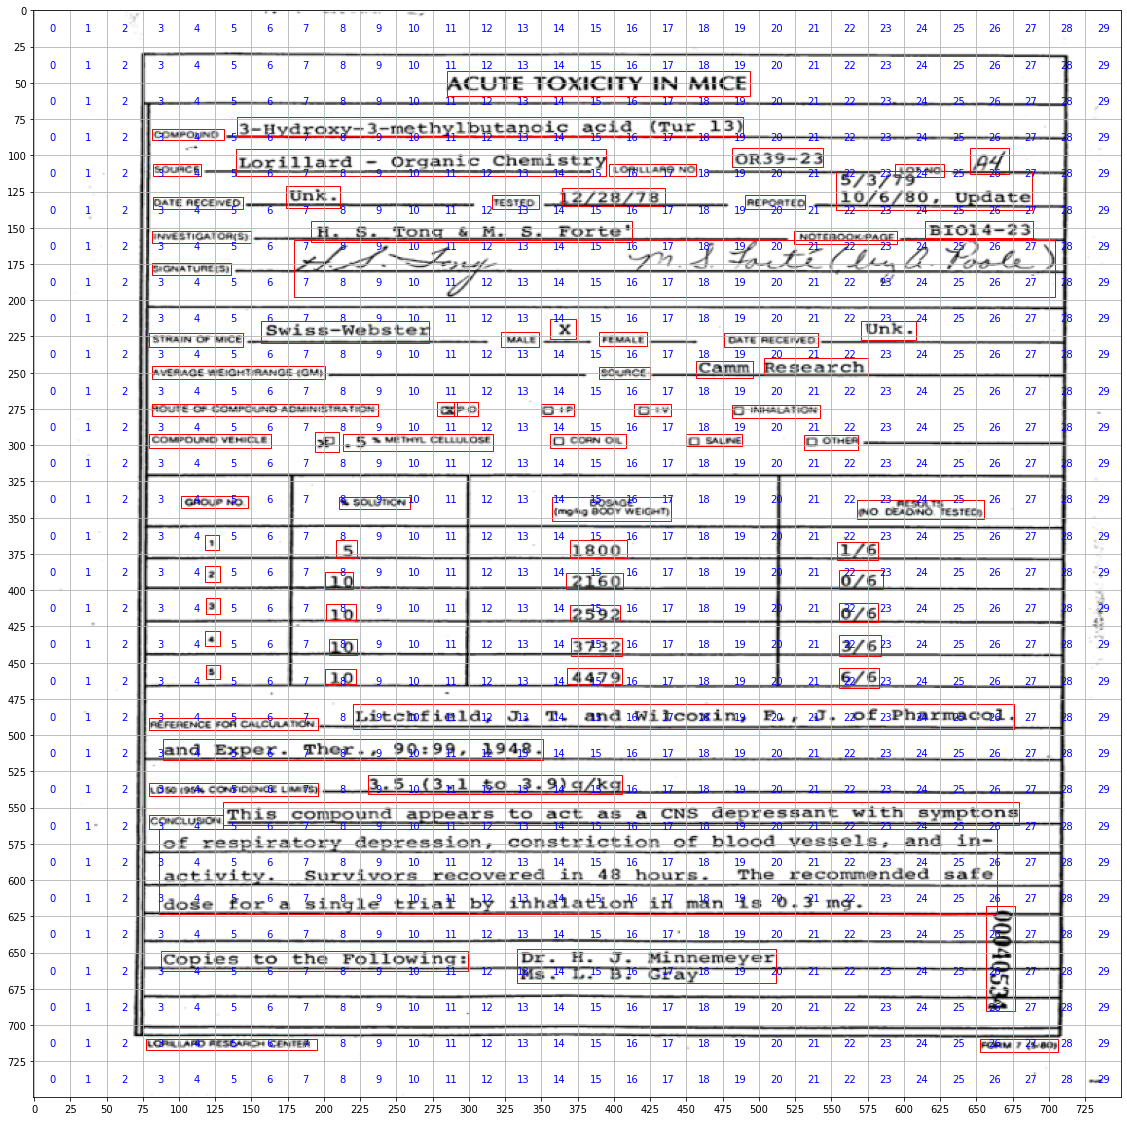

In [6]:
image, size = reader.read_image(img_filepath)
preprocess = preprocessor.PreProcessor()
png_array = preprocess.preprocess_image(model_image_size = (750, 750),
                             image=image
                             )

resize_factor_W = 750 / size[1]
resize_factor_H = 750 / size[0]
resize_array = np.array([resize_factor_W,
                         resize_factor_H,
                         resize_factor_W,
                         resize_factor_H])

plots.plot_image_from_array(img_array = png_array[:,:,0], 
                          bounding_boxes = bounding_boxes*resize_array,
                          height = 30,
                          width = 20,
                          plot_grids = True,
                           number_of_grids = 25)

## assign anchor boxes to bounding box data

Question 1: How many anchor boxes do I need?

In [7]:
import pandas as pd
bounding_boxes_list_of_dicts = get_yolo_data_from_bounding_boxes(bounding_boxes)
df = pd.DataFrame(bounding_boxes_list_of_dicts)
df.head()

,grid,x,y,w,h
0,"[4, 3]",0.247104,0.420,2.007722,0.30
1,"[3, 4]",0.938224,0.395,1.312741,0.33
2,"[4, 6]",0.613900,0.255,2.741313,0.33
3,"[4, 7]",0.343629,0.125,2.200772,0.33
4,"[20, 5]",0.444015,0.295,1.660232,0.39


In [8]:
# g = df.groupby('grid', as_index=False).count()
# print(g)
# max(g["x"])

Question 2: How big should the anchor boxes be?

(array([15., 19., 15.,  0., 15.,  6.,  2.,  2.,  2.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.3   , 0.3516, 0.4032, 0.4548, 0.5064, 0.558 , 0.6096, 0.6612,
        0.7128, 0.7644, 0.816 , 0.8676, 0.9192, 0.9708, 1.0224, 1.074 ,
        1.1256, 1.1772, 1.2288, 1.2804, 1.332 , 1.3836, 1.4352, 1.4868,
        1.5384, 1.59  , 1.6416, 1.6932, 1.7448, 1.7964, 1.848 , 1.8996,
        1.9512, 2.0028, 2.0544, 2.106 , 2.1576, 2.2092, 2.2608, 2.3124,
        2.364 , 2.4156, 2.4672, 2.5188, 2.5704, 2.622 , 2.6736, 2.7252,
        2.7768, 2.8284, 2.88  ]),
 <BarContainer object of 50 artists>)

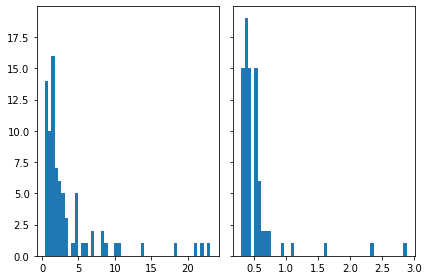

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(df["w"], bins=50)
axs[1].hist(df["h"], bins=50)


I will try 4 anchor boxes:

* 5 x 0.25
* 7.5 x 0.25
* 5 x 0.75
* 7.5 x 0.75

The difference in the bounding boxes should be mainly due to different width. The font size within each document should not differ to much. The anchor boxes are required to order the true labels within the output vector, so that several objects within one grid can be detected simultaneously and the output value pairs (p, x, y, w, h) are specialized to certain sizes of bounding boxes. This makes the model more accurate. To see which anchor box would be more appropriate, I will need to calculate the Intersection over Union (IoU).

### IoU function

In [10]:
def IoU_anchor_boxes(bounding_box_meta: list, anchor_boxes: list):
        

    for box in bounding_box_meta:
        
        area_bounding_box = box["w"] * box["h"]
        IoU_list = []
        
        for anchor_box in anchor_boxes:
            
            IoU = min(box["w"], anchor_box[0]) * min(box["h"], anchor_box[1])
            IoU_list.append(IoU)
        
        box["anchor box"] = np.argmax(IoU_list)
            
    return bounding_box_meta

anchor_boxes = [(5, 0.25),
                (7.5, 0.25),
                (5, 0.75),
                (7.5, 0.75)
               ]

test = IoU_anchor_boxes(bounding_box_meta=bounding_boxes_list_of_dicts, 
                        anchor_boxes=anchor_boxes)
print(test[0:3])

[{'grid': [4, 3], 'x': 0.2471042471042475, 'y': 0.41999999999999993, 'w': 2.0077220077220073, 'h': 0.3, 'anchor box': 2}, {'grid': [3, 4], 'x': 0.9382239382239379, 'y': 0.3949999999999996, 'w': 1.3127413127413126, 'h': 0.33, 'anchor box': 2}, {'grid': [4, 6], 'x': 0.6138996138996138, 'y': 0.2550000000000008, 'w': 2.741312741312741, 'h': 0.33, 'anchor box': 2}]


## create y true tensor

For a grid size of 50 and with 4 anchor boxes the shape of the output tensor should be 15x15x(5x4) bzw. 15x15x20. The vectorization of the tensor should result in a vector of shape (4500, 1) so that for each of the grids of the total of 15x15 grids, the model predicts the following vector: (p, x, y, w, h, p, x, y, w, h, p, x, y, w, h, p, x, y, w, h,)



In [11]:
anchor_boxes = [(5, 0.25)
#                 (7.5, 0.25),
#                 (5, 0.75),
#                 (7.5, 0.5)
               ]
bounding_boxes_list_of_dicts = get_yolo_data_from_bounding_boxes(bounding_boxes)
bounding_boxes_list_of_dicts = IoU_anchor_boxes(bounding_box_meta=bounding_boxes_list_of_dicts, 
                                                anchor_boxes=anchor_boxes)
print(bounding_boxes_list_of_dicts[0:5])

[{'grid': [4, 3], 'x': 0.2471042471042475, 'y': 0.41999999999999993, 'w': 2.0077220077220073, 'h': 0.3, 'anchor box': 0}, {'grid': [3, 4], 'x': 0.9382239382239379, 'y': 0.3949999999999996, 'w': 1.3127413127413126, 'h': 0.33, 'anchor box': 0}, {'grid': [4, 6], 'x': 0.6138996138996138, 'y': 0.2550000000000008, 'w': 2.741312741312741, 'h': 0.33, 'anchor box': 0}, {'grid': [4, 7], 'x': 0.3436293436293436, 'y': 0.125, 'w': 2.2007722007722004, 'h': 0.33, 'anchor box': 0}, {'grid': [20, 5], 'x': 0.4440154440154451, 'y': 0.29499999999999993, 'w': 1.6602316602316591, 'h': 0.39, 'anchor box': 0}]


In [22]:
y_true = np.zeros((30,30,5))

In [23]:
for bounding_box in bounding_boxes_list_of_dicts:

    x = bounding_box["x"]
    y = bounding_box["y"]
    w = bounding_box["w"]
    h = bounding_box["h"]
    grid_x = bounding_box["grid"][0]
    grid_y = bounding_box["grid"][1]
    anchor_box = bounding_box["anchor box"]
    
    offset = 5*anchor_box

    y_true[grid_x, grid_y, 0+offset] = 1  # response
    y_true[grid_x, grid_y, 1+offset:5+offset] = [x, y, w, h]

    

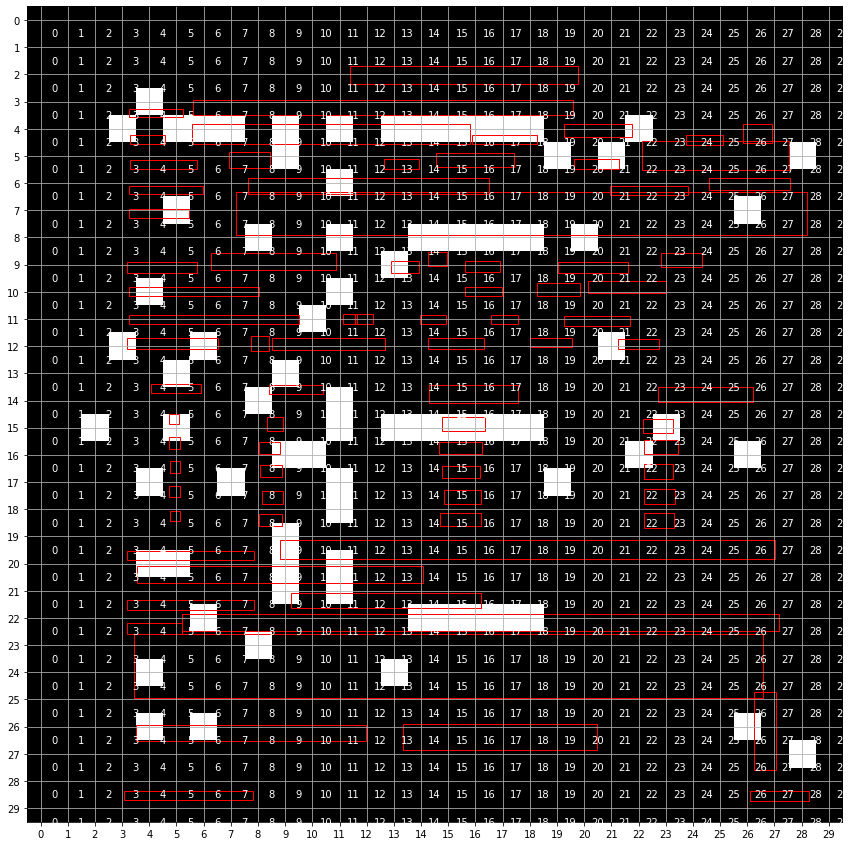

In [50]:
"""
Eigentlich sollte man aus diesem Plot die Korrektheit der y_true Matrix ableiten können...
"""

resize_factor_W = 30 / size[1]
resize_factor_H = 30 / size[0]
resize_array = np.array([resize_factor_W,
                         resize_factor_H,
                         resize_factor_W,
                         resize_factor_H])


plots.plot_image_from_array(img_array = y_true[:,:,0], 
                          bounding_boxes = bounding_boxes*resize_array,
                          height = 15,
                          width = 15,
                          plot_grids = True,
                           number_of_grids = 1,
                           color="w")

# Create Yolo Loss Function

## Intersection over Union

First, I have to create a function to calculate the Intersection over Union (IoU) for the predicted bounding box and the true label.

In [62]:
y_pred = y_true

def Intersection_over_Union(y_true, y_pred):
    
    # define variables from input tensors
    y_pred_x = y_pred[4,3,1]
    y_pred_y = y_pred[4,3,2]
    y_pred_w = y_pred[4,3,3]
    y_pred_h = y_pred[4,3,4]
    
    y_true_x = y_true[3,4,1]
    y_true_y = y_true[3,4,2]
    y_true_w = y_true[3,4,3]
    y_true_h = y_true[3,4,4]
    
    y_pred_left_edge = y_pred_x - y_pred_w / 2
    y_pred_right_edge = y_pred_x + y_pred_w / 2
    y_pred_upper_edge = y_pred_y - y_pred_h / 2
    y_pred_lower_edge = y_pred_y + y_pred_h / 2
    
    y_true_left_edge = y_true_x - y_true_w / 2
    y_true_right_edge = y_true_x + y_true_w / 2
    y_true_upper_edge = y_true_y - y_true_h / 2
    y_true_lower_edge = y_true_y + y_true_h / 2
    
    left_right_out = False
    upper_lower_out = False
    
    if y_pred_right_edge < y_true_left_edge or y_pred_left_edge > y_true_right_edge:
        
        left_right_out = True
        
    if y_pred_upper_edge > y_true_lower_edge or y_pred_lower_edge < y_true_upper_edge:
        
        upper_lower_out = True
        

    if left_right_out or upper_lower_out:
        
        IoU = 0
        return IoU
    
    intersect_left_edge = max(y_pred_left_edge, y_true_left_edge)
    intersect_right_edge = min(y_pred_right_edge, y_true_right_edge)
    intersect_upper_edge = min(y_pred_upper_edge, y_true_upper_edge)
    intersect_lower_edge = max(y_pred_lower_edge, y_true_lower_edge)
    
    intersect_h = intersect_lower_edge - intersect_upper_edge
    intersect_w = intersect_right_edge - intersect_left_edge
    
    intersect_area = intersect_h * intersect_w
    pred_area = y_pred_w * y_pred_h
    true_area = y_true_w * y_true_h
    union_area = pred_area + true_area - intersect_area
    
    IoU = intersect_area / union_area
    
    return IoU

Intersection_over_Union(y_true, y_pred)

0.4666958328776125

## YOLO loss function

Secondly, I will implement the IoU Function into the YOLO loss function presented in the YOLO paper.

In [78]:
import math

"""
Diese Funktion ist aktuell so gebaut, dass anchorboxes NICHT berücksichtigt werden, 
also es gibt nur eine Anchorbox. Es wird also keine Unterdrückung geringerer IoU durchgeführt.
Das sollte bei Gelegenheit noch ergänzt werden.
"""
def yolo_loss(y_true, y_pred):
    
    # define variables from input tensors
    y_pred_box_prob = y_pred[20,9,0]
    y_pred_x = y_pred[20,9,1]
    y_pred_y = y_pred[20,9,2]
    y_pred_w = y_pred[20,9,3]
    y_pred_h = y_pred[20,9,4]
    
    y_true_box_prob = y_true[21,9,0]
    y_true_x = y_true[21,9,1]
    y_true_y = y_true[21,9,2]
    y_true_w = y_true[21,9,3]
    y_true_h = y_true[21,9,4]

    
    # define response mask: object in grid, yes or no?
    response_mask = y_true[3,4,0]
    
    # set value for lamba_coord (default from paper = 5) and lambda_noobj (default from paper = 0.5)
    lambda_coord = 5
    lambda_noobj = 0.5
    
    # calculate sum of squared x and y differences
    x_diff = y_true_x - y_pred_x
    y_diff = y_true_y - y_pred_y
    
    x_and_y_loss = lambda_coord * response_mask * (x_diff ** 2 + y_diff ** 2)
    
    # calculate sum of squared w and h differences
    w_diff = math.sqrt(y_true_w) - math.sqrt(y_pred_w)
    h_diff = math.sqrt(y_true_h) - math.sqrt(y_pred_h)
    
    w_and_h_loss = lambda_coord * response_mask * (w_diff ** 2 + h_diff ** 2)
    
    # calculate sum of squared box prob differences
    box_prob_diff = y_true_box_prob - y_pred_box_prob
    no_object_loss = lambda_noobj * (1 - response_mask) * (0 - y_pred_box_prob)**2
    object_loss = response_mask * (1 - y_pred_box_prob)**2
    
    box_prob_loss = no_object_loss + object_loss
    
    # calculate yolo loss
    yolo_loss = x_and_y_loss + w_and_h_loss + box_prob_loss
    
    return yolo_loss
    
yolo_loss(y_true, y_pred)  

2.960974964394754